In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import bayesflow as bf
import tensorflow as tf

from functools import partial
from IPython.display import HTML
from bayesflow.simulation import Prior, Simulator, GenerativeModel

### Simulator

In [7]:
def initialize_agents(
        num_agents: int = 12,
        boundary_size: float = 10.0,
        rng=None
):
    if rng is None:
        rng = np.random.default_rng()

    positions = rng.uniform(size=(num_agents, 2)) * boundary_size
    directions = rng.uniform(size=num_agents) * 2 * np.pi

    return positions, directions


def simulator_fun(
    theta: np.array = None,
    num_agents: int = 12,
    num_timesteps: int = 100,
    boundary_size: float = 10.0,
    rng=None
):
    if rng is None:
        rng = np.random.default_rng()

    if theta is not None:
        radius, speed, eta = theta[0], theta[1], theta[2]
    else:
        radius, speed, eta = 0.1, 1.0, 0.1

    trajectories = np.zeros((num_timesteps + 1, num_agents, 2))
    headings = np.zeros((num_timesteps + 1, num_agents, 1))

    positions, directions = initialize_agents(num_agents, boundary_size, rng)
    trajectories[0] = positions
    headings[0] = directions[:, np.newaxis]

    for t in range(num_timesteps):
        new_directions = np.zeros(num_agents)
        for i in range(num_agents):
            neighbors = []
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < radius:
                    neighbors.append(directions[j])
            if neighbors:
                avg_direction = np.arctan2(np.mean(np.sin(neighbors)), np.mean(np.cos(neighbors)))
                new_directions[i] = avg_direction + rng.uniform(-eta * 0.5, eta * 0.5)
            else:
                new_directions[i] = directions[i]

        directions = new_directions
        positions[:, 0] += speed * np.cos(directions)
        positions[:, 1] += speed * np.sin(directions)
        positions = np.mod(positions, boundary_size)

        trajectories[t + 1] = positions
        headings[t + 1] = directions[:, np.newaxis]

    return np.concatenate((trajectories, headings), axis=-1, dtype=np.float32)

Making sure that it works.

In [12]:
test_path = simulator_fun()
test_path[0,0,:]

array([6.8637066, 2.345882 , 2.0218925], dtype=float32)

### Non-hierarchical priors

\begin{align}
    r &\sim \mathrm{Gamma}(2, 2),\\
    v &\sim \mathrm{Gamma}(0.5, 1),\\
    \eta &\sim \mathcal{U}(0, \pi).
\end{align}

In [9]:
def prior_fun(rng=None):
    
    if rng is None:
        rng = np.random.default_rng()
        
    r = rng.gamma(2,2)
    v = rng.gamma(0.5,1)
    eta = rng.uniform(0, np.pi)
    
    return np.array([r, v, eta], dtype=np.float32)

Again, making sure that it works.

In [10]:
test_prior = prior_fun()
test_prior

array([7.5907383, 0.6415941, 1.9887129], dtype=float32)

### Generative Model

In [14]:
param_names = [r'$r$', r'$v$', r'$\eta$']

In [160]:
prior = Prior(prior_fun=prior_fun, param_names=param_names)
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=100000)

In [205]:
prior(batch_size=1)

{'prior_draws': array([[4.184069  , 0.00710114, 2.1688993 ]], dtype=float32),
 'batchable_context': None,
 'non_batchable_context': None}

In [16]:
simulator = Simulator(simulator_fun=simulator_fun)

In [161]:
model = GenerativeModel(prior=prior, simulator=simulator, simulator_is_batched=False)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


### Configurator

In [171]:
def configurator(input_dict: dict = None, time_embedding: bool = False):
    output_dict = {}

    theta = input_dict['prior_draws']
    output_dict['parameters'] = theta

    x = input_dict['sim_data'].astype(np.float32)
    
    # Standardizing the data
    x_mean = np.mean(x)
    x_std = np.std(x)
    
    x = (x - x_mean) / x_std
    
    # Standardizing the prior draws
    params = input_dict['prior_draws'].astype(np.float32)
    params_mean = np.mean(params)
    params_std = np.std(params)
    
    params = (params - params_mean) / params_std

    # add time encoding to the data x
    if time_embedding:
        batch_size, num_timesteps, num_agents, _ = x.shape
        time_encoding = np.linspace(0, 1, num_timesteps)
        time_encoding_batched = np.tile(
            time_encoding[np.newaxis, :, np.newaxis, np.newaxis], 
            (batch_size, 1, num_agents, 1)
        )
        
    x1 = np.swapaxes(x, 2, 1)
    

    output_dict['summary_conditions'] = x1
    output_dict['parameters'] = params
    
    return output_dict

In [172]:
# Test a simulation
test_sim = model(100)
test_sim['sim_data']

array([[[[ 7.070614  ,  2.9054537 ,  3.1900816 ],
         [ 4.2552104 ,  5.274989  ,  2.8690736 ],
         [ 6.1417623 ,  8.359311  ,  1.3315393 ],
         ...,
         [ 1.0462807 ,  6.3522325 ,  4.46583   ],
         [ 0.2018667 ,  3.3660502 ,  0.44477668],
         [ 2.0035355 ,  7.662783  ,  5.0888205 ]],

        [[ 6.991722  ,  2.8099253 , -2.2610998 ],
         [ 4.327002  ,  5.174016  , -0.9527271 ],
         [ 6.1711226 ,  8.479675  ,  1.3315393 ],
         ...,
         [ 1.1217418 ,  6.2539716 , -0.9158959 ],
         [ 0.31356925,  3.4196424 ,  0.44733763],
         [ 1.9966859 ,  7.539079  , -1.6261104 ]],

        [[ 6.868803  ,  2.8254354 , -3.2671099 ],
         [ 4.214564  ,  5.121985  , -2.708184  ],
         [ 6.200483  ,  8.6000395 ,  1.3315393 ],
         ...,
         [ 1.1514333 ,  6.1336884 , -1.3287871 ],
         [ 0.25937703,  3.30823   , -2.0235128 ],
         [ 2.0788896 ,  7.4463854 , -0.84530544]],

        ...,

        [[ 5.5514307 ,  4.213554  , -0

In [173]:
np.min(test_sim['sim_data'])

-4.609498

In [174]:
out = configurator(test_sim)
out['summary_conditions']

array([[[[ 1.06241512e+00, -1.49417385e-01, -6.66063204e-02],
         [ 1.03946197e+00, -1.77210897e-01, -1.65260041e+00],
         [ 1.00369930e+00, -1.72698304e-01, -1.94529390e+00],
         ...,
         [ 6.20416403e-01,  2.31167838e-01, -1.15454984e+00],
         [ 6.51160419e-01,  2.12349623e-01, -1.15454984e+00],
         [ 6.17760122e-01,  2.25904852e-01, -1.92882568e-01]],

        [[ 2.43287593e-01,  5.39987147e-01, -1.60001978e-01],
         [ 2.64175028e-01,  5.10609508e-01, -1.27193570e+00],
         [ 2.31461674e-01,  4.95471328e-01, -1.78267717e+00],
         ...,
         [ 2.77995765e-01,  1.29104817e+00, -7.22049534e-01],
         [ 3.13894570e-01,  1.29430485e+00, -9.68422830e-01],
         [ 3.09060961e-01,  1.33002555e+00, -4.98597622e-01]],

        [[ 7.92170465e-01,  1.43735516e+00, -6.07339978e-01],
         [ 8.00712645e-01,  1.47237456e+00, -6.07339978e-01],
         [ 8.09254885e-01,  1.50739396e+00, -6.07339978e-01],
         ...,
         [ 9.78406131e-0

In [175]:
np.min(out['summary_conditions'])

-2.3358552

### Neural approximator

In [176]:
# As advised, use SetTransformer in place of DeepSet
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.GRU(units=128)),
    bf.networks.SetTransformer(input_dim=128, summary_dim=64)
])

In [177]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=3, 
    num_coupling_layers=6,
    coupling_settings={
        'kernel_regularizer': tf.keras.regularizers.l2(1e-4),
        'dropout_prob': 0.10
    }
)

In [115]:
amortizer = bf.amortizers.AmortizedPosterior(summary_net=summary_net, inference_net=inference_net)

In [178]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [179]:
amortizer.summary()

Model: "amortized_posterior_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_15 (Inv  multiple                  605292    
 ertibleNetwork)                                                 
                                                                 
 hierarchical_network_4 (Hi  multiple                  468736    
 erarchicalNetwork)                                              
                                                                 
Total params: 1074028 (4.10 MB)
Trainable params: 1073992 (4.10 MB)
Non-trainable params: 36 (144.00 Byte)
_________________________________________________________________


Simulate data for training

In [180]:
simulation = model(5000)

In [181]:
history = trainer.train_offline(simulation, epochs=200, batch_size=512, validation_sims=model(200))

Training epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 3.915


Training epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 2.740


Training epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 2.052


Training epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 1.803


Training epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 1.253


Training epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 0.808


Training epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 0.984


Training epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 0.897


Training epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 1.003


Training epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 1.284


Training epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 0.735


Training epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 0.853


Training epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 0.251


Training epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 1.639


Training epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 1.665


Training epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 0.320


Training epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 1.272


Training epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 0.802


Training epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 1.714


Training epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 0.026


Training epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 0.427


Training epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 0.021


Training epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 0.179


Training epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 1.098


Training epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 1.024


Training epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 0.754


Training epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 0.212


Training epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: -0.225


Training epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 1.165


Training epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 0.125


Training epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 0.540


Training epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 0.077


Training epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 0.189


Training epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 2.474


Training epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 1.071


Training epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: -0.225


Training epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: -0.366


Training epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 1.218


Training epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 0.627


Training epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: -0.158


Training epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 1.512


Training epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: -0.451


Training epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 4.837


Training epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 0.203


Training epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: -0.160


Training epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: -0.876


Training epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 1.325


Training epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: -0.473


Training epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: -0.900


Training epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: -0.062


Training epoch 51:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: -0.316


Training epoch 52:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: 1.334


Training epoch 53:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: -0.767


Training epoch 54:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: 0.627


Training epoch 55:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: -0.055


Training epoch 56:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: 0.368


Training epoch 57:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: 1.302


Training epoch 58:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: 0.332


Training epoch 59:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: 0.068


Training epoch 60:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: 2.555


Training epoch 61:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: 2.227


Training epoch 62:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: -0.064


Training epoch 63:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: 0.624


Training epoch 64:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: 1.920


Training epoch 65:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: 1.452


Training epoch 66:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: -0.100


Training epoch 67:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: -0.046


Training epoch 68:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: -0.038


Training epoch 69:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: -0.233


Training epoch 70:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: 0.254


Training epoch 71:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: 1.440


Training epoch 72:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: 0.400


Training epoch 73:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: 1.155


Training epoch 74:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: 0.924


Training epoch 75:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: 1.274


Training epoch 76:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: -0.272


Training epoch 77:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: -0.614


Training epoch 78:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: 2.739


Training epoch 79:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: 1.956


Training epoch 80:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: 0.081


Training epoch 81:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: -0.480


Training epoch 82:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: -0.126


Training epoch 83:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: 2.744


Training epoch 84:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: -0.703


Training epoch 85:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: -0.806


Training epoch 86:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: 0.923


Training epoch 87:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: 0.844


Training epoch 88:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: -0.464


Training epoch 89:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: 0.691


Training epoch 90:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: 2.283


Training epoch 91:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: -0.904


Training epoch 92:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: -0.412


Training epoch 93:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: 0.845


Training epoch 94:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: 0.718


Training epoch 95:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: 0.492


Training epoch 96:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: 3.593


Training epoch 97:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: -0.674


Training epoch 98:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: 0.018


Training epoch 99:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: 0.434


Training epoch 100:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: 0.103


Training epoch 101:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 101, Loss: 2.603


Training epoch 102:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 102, Loss: -0.930


Training epoch 103:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 103, Loss: 2.558


Training epoch 104:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 104, Loss: 0.417


Training epoch 105:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 105, Loss: -0.127


Training epoch 106:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 106, Loss: -0.253


Training epoch 107:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 107, Loss: -0.116


Training epoch 108:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 108, Loss: 0.472


Training epoch 109:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 109, Loss: 2.389


Training epoch 110:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 110, Loss: -0.596


Training epoch 111:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 111, Loss: -0.067


Training epoch 112:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 112, Loss: 1.241


Training epoch 113:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 113, Loss: 0.121


Training epoch 114:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 114, Loss: 0.275


Training epoch 115:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 115, Loss: 0.371


Training epoch 116:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 116, Loss: 0.157


Training epoch 117:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 117, Loss: 1.030


Training epoch 118:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 118, Loss: -0.857


Training epoch 119:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 119, Loss: -0.379


Training epoch 120:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 120, Loss: 0.955


Training epoch 121:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 121, Loss: 0.712


Training epoch 122:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 122, Loss: 0.645


Training epoch 123:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 123, Loss: 0.743


Training epoch 124:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 124, Loss: -0.667


Training epoch 125:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 125, Loss: -1.257


Training epoch 126:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 126, Loss: 0.415


Training epoch 127:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 127, Loss: -0.061


Training epoch 128:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 128, Loss: -0.271


Training epoch 129:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 129, Loss: 0.678


Training epoch 130:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 130, Loss: -0.509


Training epoch 131:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 131, Loss: -0.513


Training epoch 132:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 132, Loss: 3.464


Training epoch 133:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 133, Loss: -0.784


Training epoch 134:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 134, Loss: 1.427


Training epoch 135:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 135, Loss: -0.361


Training epoch 136:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 136, Loss: 0.637


Training epoch 137:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 137, Loss: -0.482


Training epoch 138:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 138, Loss: -0.862


Training epoch 139:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 139, Loss: 0.914


Training epoch 140:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 140, Loss: -0.969


Training epoch 141:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 141, Loss: 0.355


Training epoch 142:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 142, Loss: -0.704


Training epoch 143:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 143, Loss: 1.061


Training epoch 144:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 144, Loss: -0.110


Training epoch 145:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 145, Loss: -0.369


Training epoch 146:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 146, Loss: 0.261


Training epoch 147:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 147, Loss: 0.642


Training epoch 148:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 148, Loss: -0.063


Training epoch 149:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 149, Loss: -0.932


Training epoch 150:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 150, Loss: -0.700


Training epoch 151:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 151, Loss: -0.097


Training epoch 152:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 152, Loss: -0.629


Training epoch 153:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 153, Loss: 0.391


Training epoch 154:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 154, Loss: 0.619


Training epoch 155:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 155, Loss: -0.345


Training epoch 156:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 156, Loss: 0.192


Training epoch 157:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 157, Loss: -0.220


Training epoch 158:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 158, Loss: 0.371


Training epoch 159:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 159, Loss: -0.194


Training epoch 160:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 160, Loss: -0.387


Training epoch 161:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 161, Loss: 0.618


Training epoch 162:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 162, Loss: -0.564


Training epoch 163:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 163, Loss: 0.858


Training epoch 164:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 164, Loss: -0.464


Training epoch 165:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 165, Loss: -0.673


Training epoch 166:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 166, Loss: -0.050


Training epoch 167:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 167, Loss: -0.352


Training epoch 168:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 168, Loss: -0.152


Training epoch 169:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 169, Loss: -0.561


Training epoch 170:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 170, Loss: -0.671


Training epoch 171:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 171, Loss: 0.917


Training epoch 172:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 172, Loss: 0.486


Training epoch 173:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 173, Loss: -0.770


Training epoch 174:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 174, Loss: -0.277


Training epoch 175:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 175, Loss: 0.005


Training epoch 176:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 176, Loss: -0.581


Training epoch 177:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 177, Loss: -0.430


Training epoch 178:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 178, Loss: -0.282


Training epoch 179:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 179, Loss: -0.461


Training epoch 180:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 180, Loss: -0.432


Training epoch 181:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 181, Loss: -0.033


Training epoch 182:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 182, Loss: -0.046


Training epoch 183:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 183, Loss: -0.105


Training epoch 184:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 184, Loss: -0.269


Training epoch 185:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 185, Loss: -0.553


Training epoch 186:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 186, Loss: -0.250


Training epoch 187:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 187, Loss: -0.055


Training epoch 188:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 188, Loss: -0.215


Training epoch 189:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 189, Loss: -0.330


Training epoch 190:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 190, Loss: -0.340


Training epoch 191:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 191, Loss: -0.315


Training epoch 192:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 192, Loss: -0.326


Training epoch 193:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 193, Loss: -0.316


Training epoch 194:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 194, Loss: -0.338


Training epoch 195:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 195, Loss: -0.324


Training epoch 196:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 196, Loss: -0.286


Training epoch 197:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 197, Loss: -0.272


Training epoch 198:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 198, Loss: -0.271


Training epoch 199:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 199, Loss: -0.272


Training epoch 200:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 200, Loss: -0.272


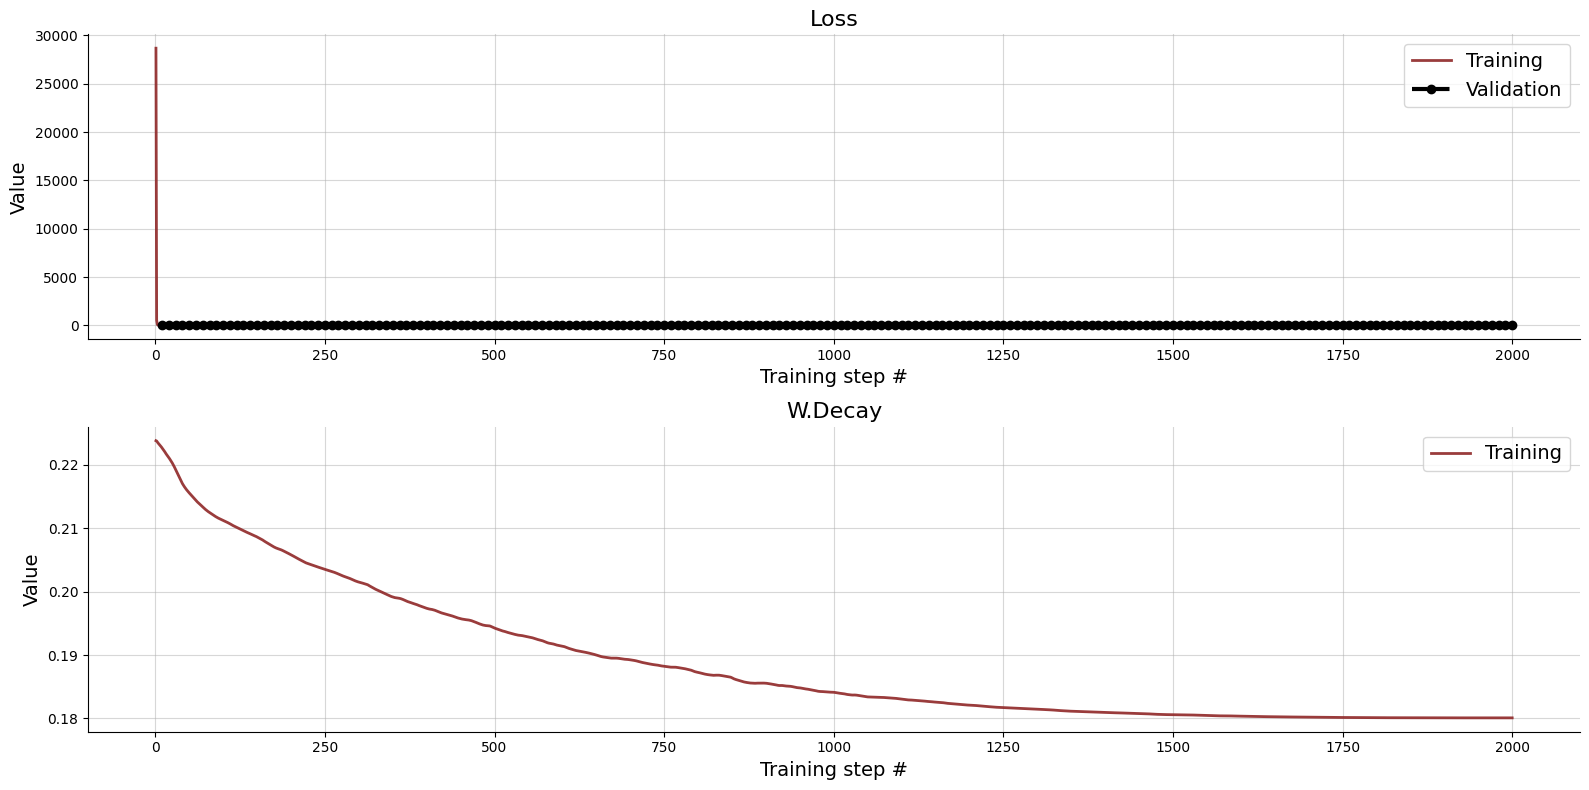

In [182]:
f = bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'])

### Validation

In [183]:
validation_sim = model(200)

In [184]:
validation_sim = configurator(validation_sim)

In [185]:
post_samples = amortizer.sample(validation_sim, n_samples=1000)
post_samples.shape

(200, 1000, 3)

In [186]:
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=10000)
prior_stds

array([[2.7923648 , 0.7108408 , 0.90838104]], dtype=float32)

In [194]:
# Prior samples have already been standardized, so the results here are omitted.
prior_samples = validation_sim["parameters"]

Parameter Recovery

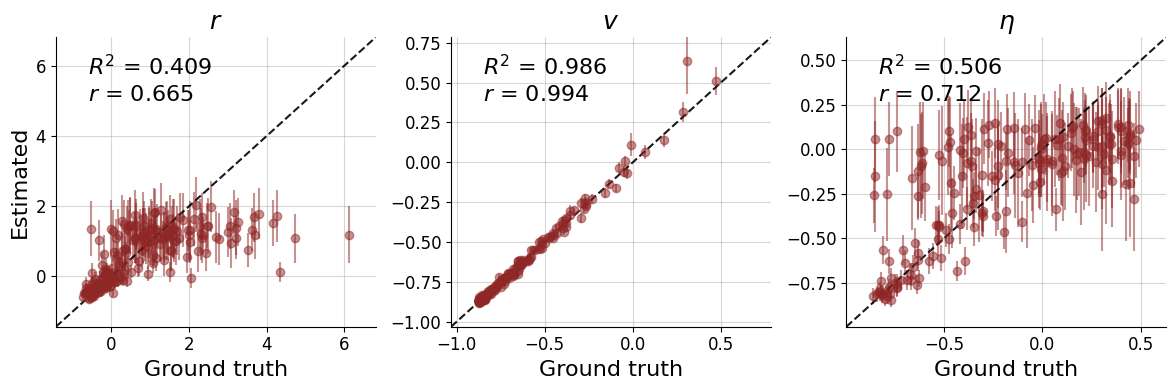

In [195]:
g = bf.diagnostics.plot_recovery(post_samples, prior_samples=prior_samples, param_names=param_names)

Simulation-based calibration

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


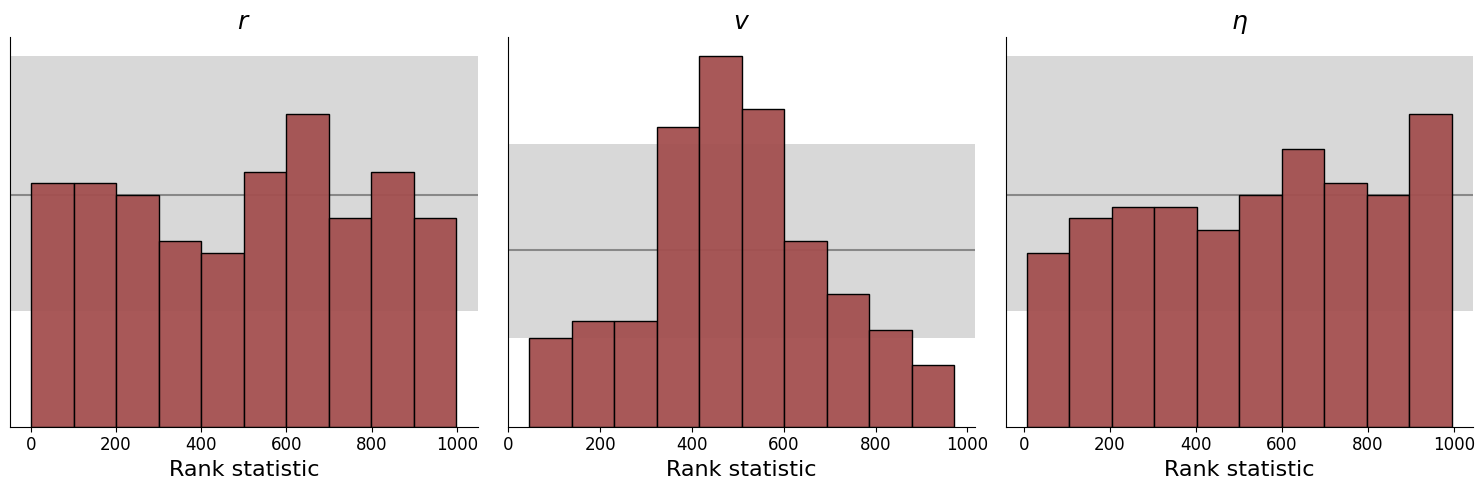

In [196]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, num_bins=10)

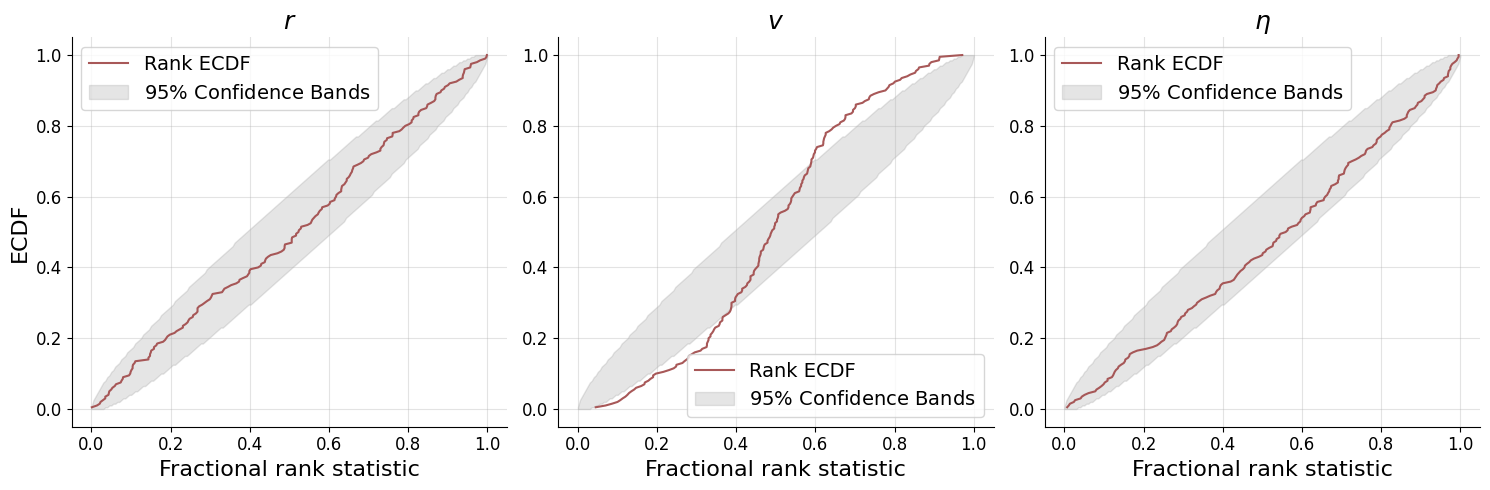

In [197]:
e = bf.diagnostics.plot_sbc_ecdf(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

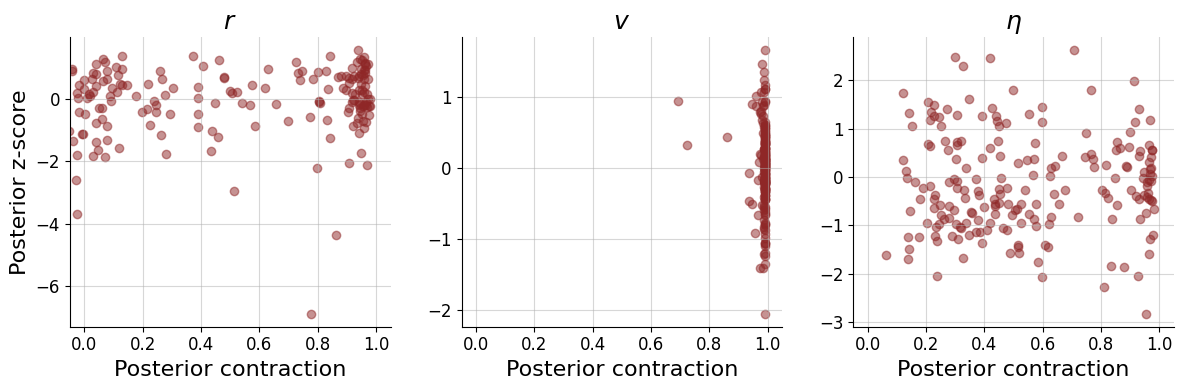

In [198]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

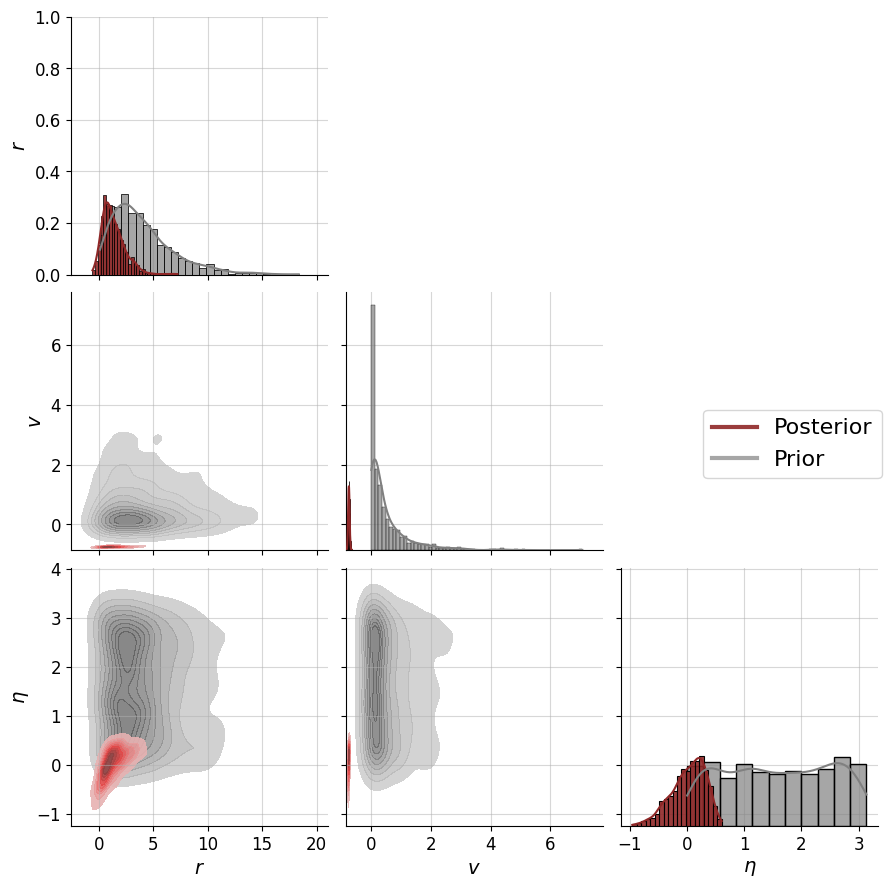

In [203]:
d = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[1], prior=prior, param_names=param_names)